# This notebook generates linear models that determine the impact of application responses on hours worked

In [52]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

import seaborn as sns
import matplotlib.pyplot as plt
import shap

# create a function for computing RMSE
def rmse(y, ypred):
    mse = np.mean((y-ypred)**2)
    rmse = np.sqrt(mse)
    return rmse

## Load data

In [3]:
data = pd.read_csv("../data/clean/model_data.csv")

In [4]:
data.head()

,ID Number,Current Grade Level,Application Year,Current Age,Rejected,EECode,EarnHours_Sum_AvgPerMonth,Preferred Pronouns_feminine,Preferred Pronouns_masculine,Preferred Pronouns_neutral,...,Commit Weekday_no,Commit Weekday_unknown,Commit Weekday_unsure,Commit Weekday_yes,Hear about source_family,Hear about source_friend,Hear about source_other,Hear about source_school,Hear about source_social media,Hear about source_unknown
0,1489.0,9.0,2022,15.339623,0,1489.0,54.53333333333333,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,unknown,11.0,2022,15.339623,1,unknown,unknown,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,1488.0,11.0,2022,15.339623,0,1488.0,90.91555555555556,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,unknown,9.0,2022,15.339623,1,unknown,unknown,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,unknown,10.0,2022,15.339623,1,unknown,unknown,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [5]:
data.tail()

,ID Number,Current Grade Level,Application Year,Current Age,Rejected,EECode,EarnHours_Sum_AvgPerMonth,Preferred Pronouns_feminine,Preferred Pronouns_masculine,Preferred Pronouns_neutral,...,Commit Weekday_no,Commit Weekday_unknown,Commit Weekday_unsure,Commit Weekday_yes,Hear about source_family,Hear about source_friend,Hear about source_other,Hear about source_school,Hear about source_social media,Hear about source_unknown
284,unknown,11.0,2020,16.0,1,unknown,unknown,1,0,0,...,0,0,0,1,0,0,0,1,0,0
285,unknown,10.0,2020,15.0,1,unknown,unknown,0,1,0,...,0,0,0,1,0,0,1,0,0,0
286,unknown,10.0,2020,15.0,1,unknown,unknown,1,0,0,...,0,0,0,1,0,0,0,1,0,0
287,unknown,10.0,2020,15.0,1,unknown,unknown,1,0,0,...,0,0,0,1,0,0,0,1,0,0
288,unknown,10.0,2020,16.0,1,unknown,unknown,0,1,0,...,0,0,0,1,0,0,0,1,0,0


# Define X, y

In [6]:
data.columns

Index(['ID Number', 'Current Grade Level', 'Application Year', 'Current Age',
       'Rejected', 'EECode', 'EarnHours_Sum_AvgPerMonth',
       'Preferred Pronouns_feminine', 'Preferred Pronouns_masculine',
       'Preferred Pronouns_neutral', 'Preferred Pronouns_unknown',
       'Program_homeschool', 'Program_other', 'Program_unknown',
       'Program_zoocamp', 'First Paying Job_0', 'First Paying Job_1',
       'Know employee_0', 'Know employee_1', 'Applied Before_0',
       'Applied Before_1', 'Comfortable speaking to crowd_0.0',
       'Comfortable speaking to crowd_1.0',
       'Comfortable speaking to crowd_unknown', 'Uncomfortable with_birds',
       'Uncomfortable with_invertebrates', 'Uncomfortable with_mammals',
       'Uncomfortable with_none', 'Uncomfortable with_reptiles',
       'Uncomfortable with_unknown', 'Extra activities_0',
       'Extra activities_1', 'Commit Summer_unknown', 'Commit Summer_unsure',
       'Commit Summer_yes', 'Commit Weekday_no', 'Commit Weekday_unk

In [10]:
~(data['ID Number'] == 'unknown')

0       True
1      False
2       True
3      False
4      False
       ...  
284    False
285    False
286    False
287    False
288    False
Name: ID Number, Length: 289, dtype: bool

## Prep data set for modeling

In [18]:
# Drop a column from one hot encoded values, specifically drop the _unknown columns where possible
# Pronouns have to be removed since they introduce perfect colinearity
# We can only use observations where we have ID numbers and hours worked
data_dropna = data[~(data['ID Number'] == 'unknown')]
data_dropna = data_dropna[~(data_dropna['EarnHours_Sum_AvgPerMonth'] == 'unknown')]

X = data_dropna[['Current Grade Level', 'Application Year', 'Current Age','Program_homeschool', 'Program_other',
       'Program_zoocamp', 'First Paying Job_1',
       'Know employee_1',
       'Applied Before_1', 'Comfortable speaking to crowd_0.0',
       'Comfortable speaking to crowd_1.0',
       'Uncomfortable with_birds',
       'Uncomfortable with_invertebrates', 'Uncomfortable with_mammals',
       'Uncomfortable with_none', 'Uncomfortable with_reptiles',
       'Extra activities_1', 'Commit Summer_unsure',
       'Commit Summer_yes', 'Commit Weekday_no', 
       'Commit Weekday_unsure', 'Commit Weekday_yes',
       'Hear about source_family', 'Hear about source_friend',
       'Hear about source_other', 'Hear about source_school',
       'Hear about source_social media']]

y = data_dropna['EarnHours_Sum_AvgPerMonth']

In [21]:
# Identify perfect multicollinearity
for i,a in enumerate(X.columns):
    for j,b in enumerate(X.columns):
        k = sum(X[X.columns[i]]+X[X.columns[j]])
        if k == len(X):
            print(f"{a}, {b}: {k}")

Program_zoocamp, Commit Summer_yes: 36
Uncomfortable with_birds, Commit Weekday_yes: 36
Commit Summer_unsure, Commit Summer_yes: 36
Commit Summer_yes, Program_zoocamp: 36
Commit Summer_yes, Commit Summer_unsure: 36
Commit Weekday_no, Commit Weekday_yes: 36
Commit Weekday_unsure, Commit Weekday_yes: 36
Commit Weekday_yes, Uncomfortable with_birds: 36
Commit Weekday_yes, Commit Weekday_no: 36
Commit Weekday_yes, Commit Weekday_unsure: 36


In [22]:
X = X.drop(columns = ['Commit Weekday_yes', 'Commit Summer_yes'])

In [23]:
X

,Current Grade Level,Application Year,Current Age,Program_homeschool,Program_other,Program_zoocamp,First Paying Job_1,Know employee_1,Applied Before_1,Comfortable speaking to crowd_0.0,...,Uncomfortable with_reptiles,Extra activities_1,Commit Summer_unsure,Commit Weekday_no,Commit Weekday_unsure,Hear about source_family,Hear about source_friend,Hear about source_other,Hear about source_school,Hear about source_social media
0,9.0,2022,15.339623,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,11.0,2022,15.339623,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
6,11.0,2022,15.339623,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
8,10.0,2022,15.339623,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,10.0,2022,15.339623,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
16,9.0,2022,15.339623,0,1,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
17,10.0,2022,15.339623,0,1,0,1,0,0,0,...,1,1,0,0,0,0,0,1,0,0
18,9.0,2022,15.339623,0,1,0,1,1,0,0,...,0,1,1,0,0,0,1,0,0,0
19,9.0,2022,15.339623,0,1,0,1,1,0,0,...,1,1,0,0,0,0,1,0,0,0
22,9.0,2022,15.339623,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


## Perform OLS

In [33]:
# OLS using statsmodels
y = y.astype(float)
X = X.astype(float)

x = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                                OLS Regression Results                               
Dep. Variable:     EarnHours_Sum_AvgPerMonth   R-squared:                       0.721
Model:                                   OLS   Adj. R-squared:                  0.349
Method:                        Least Squares   F-statistic:                     1.939
Date:                       Tue, 21 Feb 2023   Prob (F-statistic):             0.0974
Time:                               22:14:15   Log-Likelihood:                -141.71
No. Observations:                         36   AIC:                             325.4
Df Residuals:                             15   BIC:                             358.7
Df Model:                                 20                                         
Covariance Type:                   nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [34]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

## Diagnose OLS model

In [35]:
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

C:\Users\lawto\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
C:\Users\lawto\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Residuals')

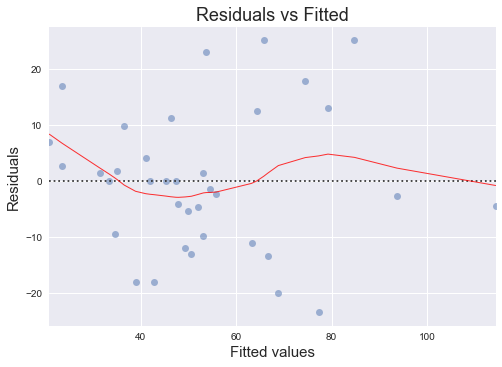

In [36]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

C:\Users\lawto\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


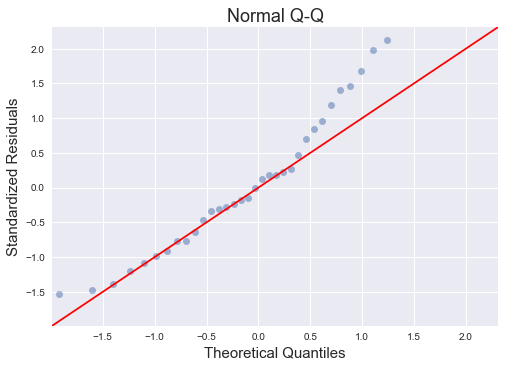

In [37]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]))

C:\Users\lawto\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


KeyError: 23

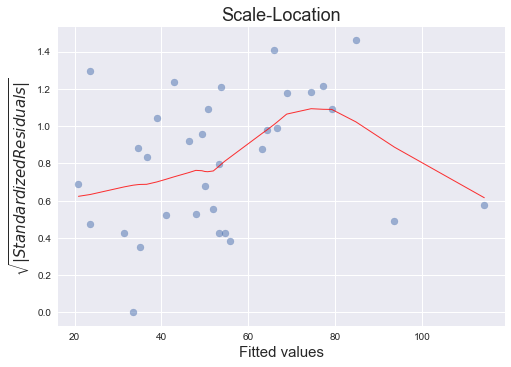

In [38]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                            xy=(model_fitted_y[i],
                            model_norm_residuals_abs_sqrt[i]))

C:\Users\lawto\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


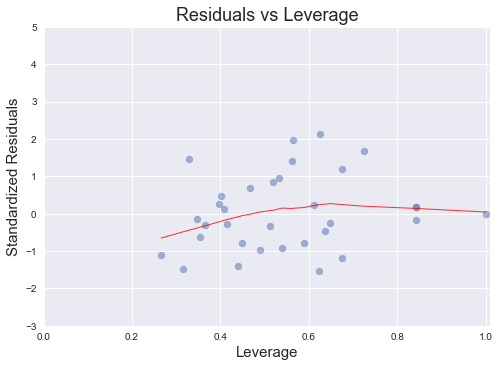

In [39]:
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i,
    xy=(model_leverage[i],
        model_norm_residuals[i]))

## Test how well a linear model generalizes

In [76]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [77]:
# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [78]:
# generate predictions
preds_train = model.predict(X_train)
preds = model.predict(X_test)

# compute rmse
print(f'train rmse: {rmse(y_train, preds_train)}')
print(f'test rmse: {rmse(y_test, preds)}')

train rmse: 9.858821832728426
test rmse: 30.33779449666378


In [79]:
# Our model is an RMSE of 33.83, seems reasonable when looking at a range of values for y_train
# however the delta between training and test rmse is quite large, indicating high model variance
y_train

19      45.088889
75      48.828889
22      41.952500
278     26.326154
0       54.533333
9       53.571111
182     36.945556
68     109.888889
79     109.888889
16      43.832222
27      90.915556
2       90.915556
131     40.462222
6       46.382222
275     24.831667
8       43.358889
251     44.670000
110     45.223571
157     33.465000
26      92.295556
108     53.196875
77      47.401905
135     25.070000
17      57.556667
80      37.580000
18      32.795556
54      53.828889
174     76.846364
Name: EarnHours_Sum_AvgPerMonth, dtype: float64

## Using SHAP for feature importance

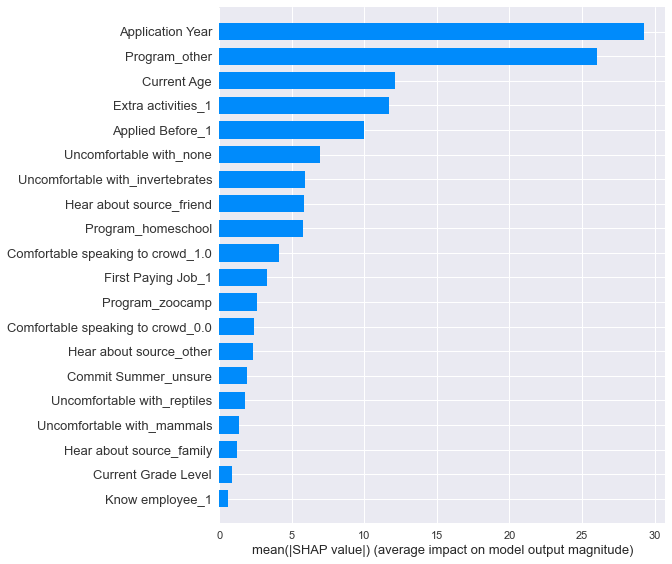

In [80]:
explainer = shap.explainers.Linear(model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

## Is ridge regression better than linear regression?

In [81]:
# Fit the model
rr = Ridge(alpha = 1.0)
rr.fit(X_train, y_train)

Ridge()

In [82]:
# generate predictions
preds_train = rr.predict(X_train)
preds = rr.predict(X_test)

# compute rmse
print(f'train rmse: {rmse(y_train, preds_train)}')
print(f'test rmse: {rmse(y_test, preds)}')

train rmse: 12.800364063621505
test rmse: 23.08882701749366


## Use 5x2 validation to select an ideal alpha

In [83]:
# define a function for doing five-by-two validation
def FiveByTwo_Validation_RR(train_data, train_targets, lam_vals):
    n = train_data.shape[0]
    res = np.zeros((10, len(lam_vals)))
    for j, k in enumerate(lam_vals):
        for i in range(5):

            # shuffle data
            shuffle_ix = np.random.choice(n, size=n, replace=False)
            shuffled = train_data.iloc[shuffle_ix, :]
            tgt_shuffled = train_targets.iloc[shuffle_ix]

            # split evenly into train / valid
            train = shuffled.iloc[:int(np.floor(n/2)), :]
            ttgt = tgt_shuffled[:int(np.floor(n/2))]
            valid = shuffled.iloc[int(np.floor(n/2)):, :]
            vtgt = tgt_shuffled[int(np.floor(n/2)):]

            # fit model on train
            model = Ridge(alpha=k).fit(train, ttgt)
            
            # predict on valid
            preds = model.predict(valid)

            # compute mse
            res[2*i, j] = mse(preds, vtgt)
            
            # now swap: train on "validation" set and predict on "train" set
            model_swap = Ridge(alpha=k).fit(valid, vtgt)
            preds_swap = model_swap.predict(train)
            
            # compute mse again
            res[2*i+1, j] = rmse(preds_swap, ttgt)
        
    return res

In [84]:
# define our array of lambdas
lam_vals = np.logspace(-2,4,19)

# run validation function
res = FiveByTwo_Validation_RR(X_train, y_train, lam_vals)

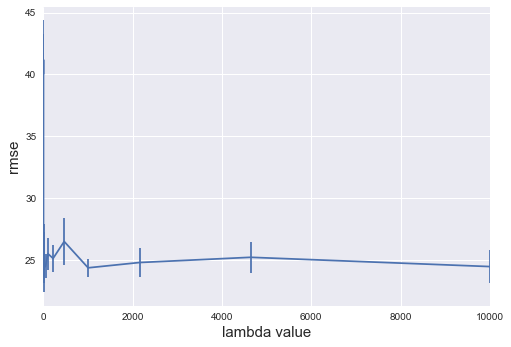

In [85]:
# plot results
plt.errorbar(lam_vals, res.mean(axis=0), res.std(axis=0)/np.sqrt(res.shape[0]))
plt.xlim([lam_vals[0]-0.5, lam_vals[-1]+0.5])
plt.xlabel('lambda value')
plt.ylabel('rmse')
plt.show()

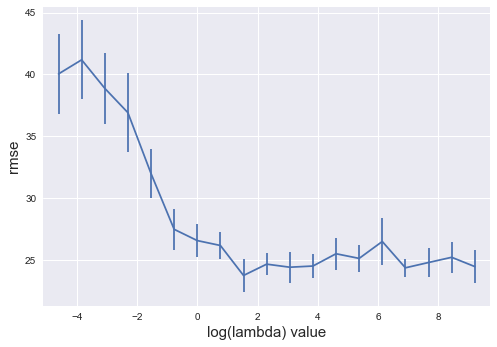

In [86]:
# plot log of lambdas so we can better see the trend among small values
plt.errorbar(np.log(lam_vals), res.mean(axis=0), res.std(axis=0)/np.sqrt(res.shape[0]))
plt.xlim([np.log(lam_vals[0])-0.5, np.log(lam_vals[-1])+0.5])
plt.xlabel('log(lambda) value')
plt.ylabel('rmse')
plt.show()

In [87]:
# select best lambda
best_lam_ix = np.argmin(np.mean(res, axis=0))
best_lam = lam_vals[best_lam_ix]

best_lam

4.6415888336127775

In [88]:
# instantiate new Ridge
rr_best = Ridge(alpha = best_lam)

# fit to data
rr_best.fit(X_train, y_train)

Ridge(alpha=4.6415888336127775)

In [89]:
# generate predictions
new_preds_train = rr_best.predict(X_train)
new_preds = rr_best.predict(X_test)

print(f'train rmse: {rmse(y_train, new_preds_train)}')
print(f'test rmse: {rmse(y_test, new_preds)}')

# the new results are more promising than linear regression, and the delta between train/test rmse is lower

train rmse: 15.40294828669207
test rmse: 22.270482924410192


## New SHAP values for our best model

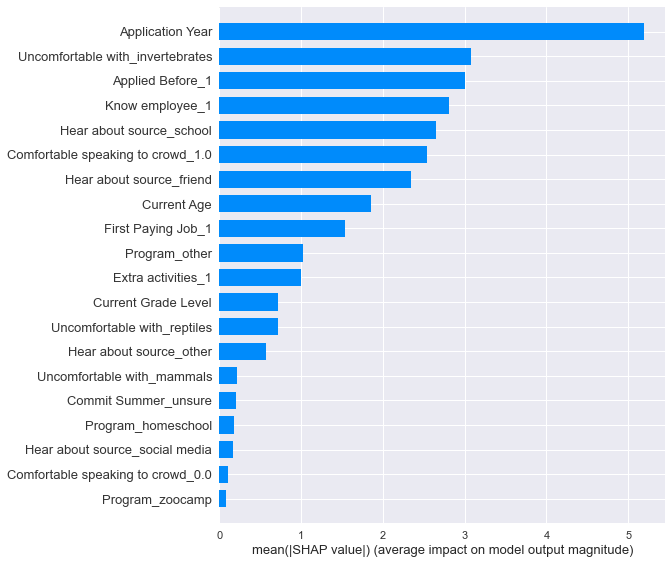

In [90]:
explainer = shap.explainers.Linear(rr_best, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

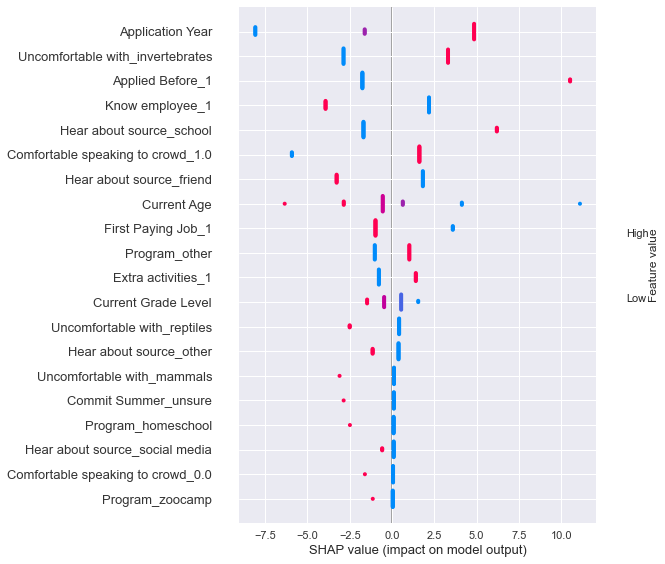

In [91]:
shap.summary_plot(shap_values, X_train)